<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/UDOP/Fine_tune_UDOP_on_a_custom_dataset_(toy_RVL_CDIP_dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tune UDOP for document image classification

In this tutorial, I'll showcase how one can fine-tune UDOP by Microsoft for document AI tasks such as classifying to which category a given document image belongs.

UDOP is pretty similar to models like [Donut](https://huggingface.co/docs/transformers/en/model_doc/donut) and [Pix2Struct](https://huggingface.co/docs/transformers/model_doc/pix2struct) which take an image as input, and produce text as output using a vision-encoder, GPT-based text decoder architecture. However, unlike Donut and PixStruct, UDOP additionally leverages an OCR engine to help the model in producing the correct text.

Said differently, you can view UDOP as a T5 model, but leveraging LayoutLMv3 as encoder combined with a T5 text decoder.

## Set-up environment

Let's start by installing the required libraries:

* 🤗 Transformers for the UDOP model
* 🤗 Dataset to load a toy dataset from the hub
* SentencePiece for the tokenizer
* Bitsandbytes for the memory-efficient 8-bit optimizer
* Tesseract for the OCR engine.

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

Cloning into 'transformers'...
remote: Enumerating objects: 234893, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 234893 (delta 39), reused 61 (delta 39), pack-reused 234818
Receiving objects: 100% (234893/234893), 225.24 MiB | 23.48 MiB/s, done.
Resolving deltas: 100% (166476/166476), done.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
!pip install -q datasets sentencepiece bitsandbytes

In [3]:
!sudo apt install tesseract-ocr
!pip install -q pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


## Load data

Next, let's load a toy dataset from the 🤗, which I prepared. It's a subset of the [RVL-CDIP dataset](https://huggingface.co/datasets/aharley/rvl_cdip), which is a benchmark often used for document image classification.

The docs for loading a custom dataset is [here](https://huggingface.co/docs/datasets/en/loading). You can optionally push it to the hub by calling `push_to_hub()` on your dataset, such that you can reload it using `load_dataset`.

In [4]:
from datasets import load_dataset

dataset = load_dataset("nielsr/rvl_cdip_10_examples_per_class_donut")

The dataset consists of a few document images with a corresponding label. We have both a training split and a test split.

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'ground_truth'],
        num_rows: 160
    })
    test: Dataset({
        features: ['image', 'label', 'ground_truth'],
        num_rows: 160
    })
})

Lets take a look at a random training example.

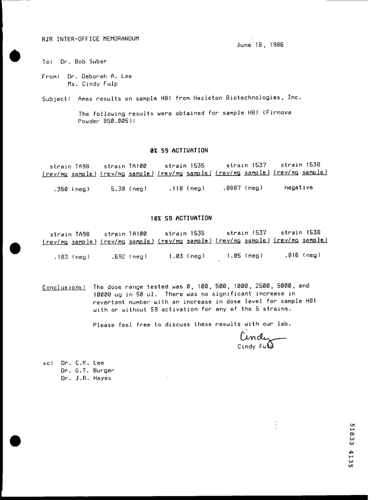

In [6]:
example = dataset["train"][5]
image = example['image']
# let's make the image a bit smaller when visualizing
width, height = image.size
display(image.resize((int(width*0.5), int(height*0.5))))

We can load the id2label mapping of the RVL-CDIP dataset from the hub:

In [7]:
from huggingface_hub import hf_hub_download
import json

repo_id = "huggingface/label-files"
filename = "rvlcdip-id2label.json"
id2label = json.load(open(hf_hub_download(repo_id, filename, repo_type="dataset"), "r"))
id2label = {int(k):v for k,v in id2label.items()}
print(id2label)

{0: 'letter', 1: 'form', 2: 'email', 3: 'handwritten', 4: 'advertisement', 5: 'scientific report', 6: 'scientific publication', 7: 'specification', 8: 'file folder', 9: 'news article', 10: 'budget', 11: 'invoice', 12: 'presentation', 13: 'questionnaire', 14: 'resume', 15: 'memo'}


In this case, the image corresponds to a "letter".

In [8]:
id2label[example["label"]]

'letter'

To prepare this pair of (image, label) for the model, we can leverage the `UdopProcessor` class.


This class works very similar to LayoutLMv2/LayoutLMv3's processor: it prepares the inputs required by the model.

Internally, it will:
* use `LayoutLMv3ImageProcessor` to turn the image into `pixel_values` (by resizing, rescaling and normalizing the image), as well as to apply OCR on the image to get a list of words + corresponding coordinates. By default, Tesseract is used as OCR engine.
- use `UdopTokenizer` to turn the words + coordinates into token-level `input_ids`, `attention_mask` and `bbox`.

Note that one can also decide to use another OCR engine of choice. Refer to the docs for usage.

In [9]:
from transformers import UdopProcessor

processor = UdopProcessor.from_pretrained("microsoft/udop-large")
print(type(processor.image_processor))
print(type(processor.tokenizer))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


<class 'transformers.models.layoutlmv3.image_processing_layoutlmv3.LayoutLMv3ImageProcessor'>
<class 'transformers.models.udop.tokenization_udop_fast.UdopTokenizerFast'>


In [10]:
encoding = processor(images=image.convert("RGB"), return_tensors="pt")
for k,v in encoding.items():
  print(k,v.shape)

input_ids torch.Size([1, 393])
attention_mask torch.Size([1, 393])
bbox torch.Size([1, 393, 4])
pixel_values torch.Size([1, 3, 224, 224])


In [11]:
processor.batch_decode(encoding.input_ids)

['RJR INTER-OFFICE MEMORANDUM June 18, 1986 Jo: Or. Bob Suber From: Or. Deboreh A. Lee Ms. Cindy Fulp Ames results on sample H8! fron Hazleton Biotechnologies, Inc. Subject: The following results were obtained for sample i181 (Firnova Powder 850.005): 0% S9 ACTIVATION strain TA98—stroin TAIO® strain 1835 strain 1837 strain 1538 rev/ng sample<unk> (rev/ng sample) (rev/mg sample) (rev/ng sample) (rev/ng sample) -350 (neg) 9.30 (neg) 118 (neg) 0887 (neg) negative 10% $9 ACTIVATION strain TAS strain TAI@® strain 1835 strain 1537 strain 1538 (reving sample) (rev/ng sample) (rev/ng sample) (rev/na sample) <unk>rev/na sample) +183 (neg) +692 (neg) 1.03 (neg) 1.05 (neg) -816 (neg) The dose range tested vas 0, 100, 500, 1000, 2500, S000, and 10000 ug in 50 ul. There was no significant increase in revertant number with an increase in dose level for sample HB! uith or without $3 activation for any of the 5 strains. Conc] us ion: Please feel free to discuss these results with our leb. xe: Dr. C.K.

## Load model

Next, let's load the UDOP model which has been pre-trained already using a language modeling objective.

In [12]:
from transformers import UdopForConditionalGeneration

model = UdopForConditionalGeneration.from_pretrained("microsoft/udop-large")

## Create PyTorch Dataset

Next we create a regular PyTorch dataset. Each item of the dataset consists of the pixel_values, input_ids, attention_mask, bbox inputs as well as corresponding labels for the model.

In [13]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    # get item
    sample = self.dataset[idx]

    # prepare inputs for the model
    image = sample["image"].convert("RGB")
    encoding = self.processor(images=image, truncation=True, padding="max_length", return_tensors="pt")

    encoding = {k:v.squeeze() for k,v in encoding.items()}

    # prepare targets
    label = id2label[sample["label"]]
    target_sequence = f"document image classification. {label}"
    encoding["labels"] = self.processor(text_target=target_sequence,
                                        padding="max_length", max_length=10, truncation=True,
                                        return_tensors="pt").input_ids.squeeze()

    return encoding

In [14]:
import datasets

train_dataset = CustomDataset(dataset["train"], processor)

In [15]:
train_example = train_dataset[8]

print(train_example.keys())

dict_keys(['input_ids', 'attention_mask', 'bbox', 'pixel_values', 'labels'])


In [16]:
print(processor.batch_decode(train_example["input_ids"]))

['Doc', 'ex', 'der', '29,', '1964', 'Mr', '.', 'Dur', 'n', 'o', 'y', 'C', '.', 'You', 'n', 'At', 't', 'or', 'n', 'o', 'y', 'at', 'Law', '2', '21', 'Ash', 'n', 'un', 'street', 'P', '.', 'O', '.', 'Box', '5', '16', 'S', 'ault', 'Ste', ',', 'Vari', 'e', ',', 'Me', 'h', 'i', 'can', '4', '978', '4', '', 'AN', 'RE', 'P', 'LY', 'RE', 'FER', '70', ':', 'Our', 'Fil', 'o', 'Yo', '.', '25', '15', 'Joan', 'wi', 'ital', 'a', ',', 'Ad', 'n', 'r', 'x', '.', '', 'v', 'y', '.', 'Py', 'Lor', 'illard', 'end', 'A', 'erie', 'an', '’', 'To', 'b', 'acco', 'Company', 'Dear', 'K', 'r', ',', 'Vo', 'un', 't', 'I', 'have', 'rev', 'ies', 'filed', 'in', 'this', '4', 'your', 'No', 'tion', 'which', 'you', 'have', 'caused', 'to', 'be', '', 'n', 'at', 't', 'or', '.', 'I', 'be', 'l', 'd', 'c', 've', 'that', 'ran', 'y', 'of', 'the', '', 'n', 'atter', 's', 'of', '', 'u', 'h', 'ich', 'you', '', 'e', ':', 'at', 'this', 'particular', 'tine', '', 'd', 'n', 'e', 'o', 'far', 'as', 'the', 'pl', 'sack', 'n', ',', 'concerned', '',

In [17]:
print(processor.batch_decode(train_example["labels"]))

['document', 'image', 'classification', '.', 'letter', '</s>', '<pad>', '<pad>', '<pad>', '<pad>']


## Create PyTorch DataLoader

Next, we create a corresponding PyTorch DataLoader, which gives us batches of data. As the model is quite memory intensive, we'll use a batch size of 1 here, which can be combined with gradient accumulation/checkpoint to increase training efficiency.

I highly recommend to read the ["efficient training on a single GPU"](https://huggingface.co/docs/transformers/en/perf_train_gpu_one) guide if you want to know more.

In [18]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

In [19]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

input_ids torch.Size([1, 512])
attention_mask torch.Size([1, 512])
bbox torch.Size([1, 512, 4])
pixel_values torch.Size([1, 3, 224, 224])
labels torch.Size([1, 10])


In [20]:
print(processor.batch_decode(batch["input_ids"][0]))

['January', '29,', '1998', 'Bible', 'Opening', 'Re', 'mark', 's', '', '-', 'House', 'Commerce', 'Com', ':', 'Mr', '.', 'Chairman', 'and', 'Members', 'of', 'the', 'Committee', ':', '1', "'", 'm', 'Ge', 'off', 'Bible', '.', 'For', 'the', 'past', 'three', 'years', 'I', 'have', 'been', 'Chairman', 'and', 'Chief', 'Executive', 'Officer', 'of', 'Philip', 'Morris', 'Companies', '.', 'I', 'appreciate', 'the', 'opportunity', 'to', 'appear', 'before', 'the', 'Committee', 'today', 'and', 'to', 'discuss', 'with', 'you', 'the', 'Pro', 'posed', 'Resolution', '.', '1', 'am', 'proud', 'to', 'represent', 'the', 'largest', 'consumer', '-', 'product', 's', 'company', 'in', 'the', 'world', 'and', 'even', 'proud', 'er', 'of', 'our', 'more', 'than', '1', '50,000', 'employees', '.', '', '.', '', '.', '', '70,000', 'in', 'the', 'United', 'States', 'alone', '.', '', '.', '', '.', 'who', 'develop', ',', 'manufacture', 'and', 'market', 'leading', 'brands', 'in', 'the', 'tobacco', ',', 'food', 'and', 'beer', 'ind

In [21]:
print(processor.batch_decode(batch["labels"][0]))

['document', 'image', 'classification', '.', 'presentation', '</s>', '<pad>', '<pad>', '<pad>', '<pad>']


In [28]:
batch["bbox"].type()

'torch.cuda.LongTensor'

## Train the model

Next, let's train the model!

In [25]:
import transformers
import torch
import bitsandbytes as bnb
from tqdm.auto import tqdm

transformers.utils.logging.set_verbosity_error()

# we'll replace the memory-intensive AdamW by Adam-8bit
# so rather than using this:
# from torch.optim import AdamW
# optimizer = AdamW(model.parameters(), lr=5e-5)
# we'll use this:
optimizer = bnb.optim.Adam8bit(model.parameters(), lr=5e-5)

# put model on GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(10):  # loop over the dataset multiple times
  print("Epoch:", epoch)
  for batch in tqdm(train_dataloader):
      # get the inputs;
      batch = {k:v.to(device) for k,v in batch.items()}
      input_ids = batch["input_ids"]
      attention_mask = batch["attention_mask"]
      bbox = batch["bbox"]
      pixel_values = batch["pixel_values"]
      labels = batch["labels"]

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward pass
      outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask,
          bbox=bbox,
          pixel_values=pixel_values,
          labels=labels,
      )
      loss = outputs.loss
      loss.backward()
      optimizer.step()

      print("Loss:", loss.item())


  if epoch % 2 == 0:
      # run a random autoregressive generation
      model.eval()

      predictions = model.generate(input_ids=input_ids, attention_mask=attention_mask, bbox=bbox)
      print("Predictions:", processor.batch_decode(predictions, skip_special_tokens=True))

      # put model back in training mode
      model.train()

Epoch: 0


  0%|          | 0/160 [00:00<?, ?it/s]

Loss: 0.009311027824878693
Loss: 0.698961079120636
Loss: 0.6105748414993286
Loss: 0.04573800787329674
Loss: 0.017915325239300728
Loss: 0.04596346244215965
Loss: 0.005824372638016939
Loss: 0.029294857755303383
Loss: 0.05546893924474716
Loss: 0.025749165564775467
Loss: 0.5225600004196167
Loss: 0.6716193556785583
Loss: 0.10908721387386322
Loss: 0.18589894473552704
Loss: 0.030583759769797325
Loss: 0.13334789872169495
Loss: 0.38007161021232605
Loss: 0.041963137686252594
Loss: 0.007802598178386688
Loss: 0.11939841508865356
Loss: 0.23295409977436066
Loss: 0.009234707802534103
Loss: 0.8880694508552551
Loss: 0.0046111224219202995
Loss: 0.21347686648368835
Loss: 0.014984461478888988
Loss: 0.0041926768608391285
Loss: 0.9880384206771851
Loss: 0.3298519551753998
Loss: 0.19496679306030273
Loss: 0.6379857659339905
Loss: 0.05337008833885193
Loss: 0.1607438176870346
Loss: 0.15273332595825195
Loss: 0.2749519646167755
Loss: 0.0502079613506794
Loss: 0.02470693178474903
Loss: 0.17771443724632263
Loss: 0.52

RuntimeError: mean(): could not infer output dtype. Input dtype must be either a floating point or complex dtype. Got: Long

## Inference

At inference time, it's recommended to leverage the generate method for autoregressive generation of text.

Refer to [this blog post](https://huggingface.co/blog/how-to-generate) if you want to know all about the various ways of decoding text from Transformers.

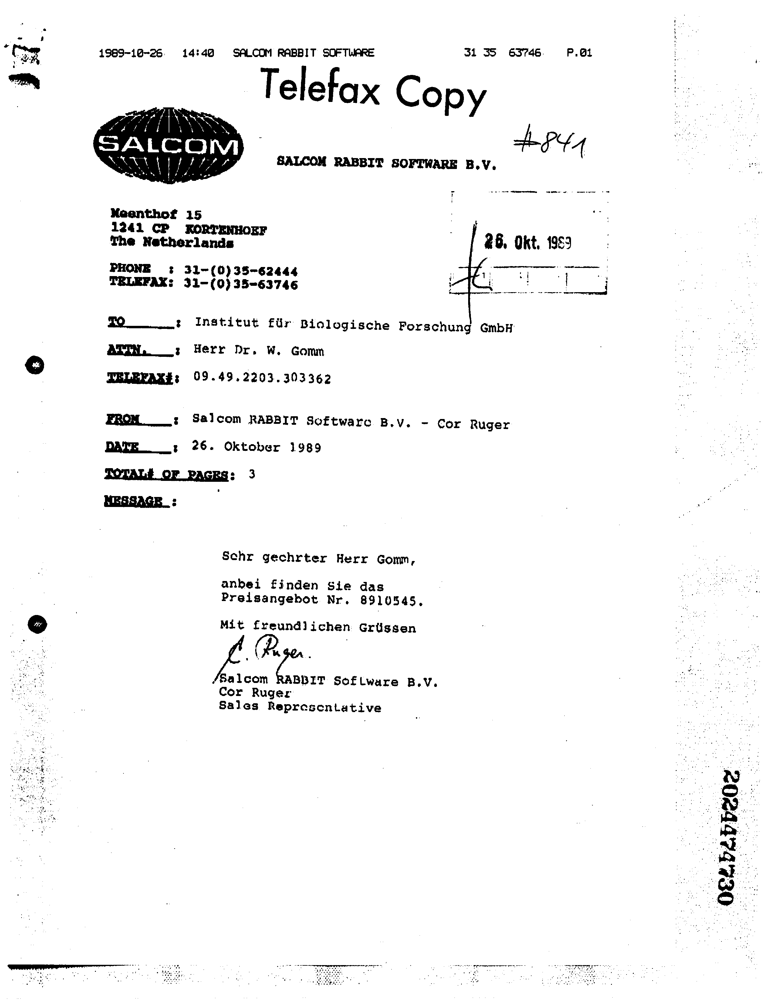

In [42]:
# let's take an image from the original test set
test_example = dataset["test"][10]

test_image = test_example["image"]
test_image

In [43]:
# prepare the image for the model (OCR is applied by the processor)
inputs = processor(test_image.convert("RGB"), return_tensors="pt").to(device)
for k,v in inputs.items():
  print(k,v.shape)

input_ids torch.Size([1, 246])
attention_mask torch.Size([1, 246])
bbox torch.Size([1, 246, 4])
pixel_values torch.Size([1, 3, 224, 224])


In [44]:
processor.batch_decode(inputs.input_ids)

['14:40 SALCOM RABBIT SOFTURRE 33S 63746. POL Telefax Copy 1969-10-26. Ae SALCOM RABBIT SOFTWARE B.V. Meonthot 15 124 CP XoRTENHORF ‘the Netherlands 26, Okt. 1983 PHONE + 31-(0)35-62444 Ae, C TELEFAX: 31-(0)38-63746 t a 0. # Institut flr Diologische Forschung GmbH ARM: Herr pr. Ww. Gomm TBLERAKEs 09.49.2203. 303362 FROM___: Salcom RABBIT Software B.v. - Cor Ruger DATE. _+ 26. Oktober 1989 ‘TOTALS OF PAGES: 3 Schr gechrter Herr Gomm, anbei finden sie das Preisangebot Nr. 8910545. Mit freundlichen Grissen & ‘ ye : icon $na027 Sottnere B.<unk>. Cor Ruger Sales Represcntative OfL.bebbeor</s>']

In [45]:
# autoregressive generation
model.eval()
generated_ids = model.generate(**inputs, max_new_tokens=10)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)

document image classification. form


Let's compare that to the ground truth label:

In [46]:
id2label[test_example["label"]]

'form'